In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [2]:
tf.__version__

'1.5.0'

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
# Convolution layer1 parameters
f_size1 = 5
num_f1= 16

# Convolution layer1 parameters
f_size2 = 5
num_f2= 36

#number of hidden units/neurons in fully connected layer
fc_size = 128


In [5]:
# Different train/validation/test size in dataset
print("Training set : {}".format(len(data.train.labels)))
print("Validation set : {}".format(len(data.validation.labels)))
print("Test set : {}".format(len(data.test.labels)))

Training set : 55000
Validation set : 5000
Test set : 10000


In [6]:
#Creating test labels with correct classes
data.test.cls= np.argmax(data.test.labels,axis=1)

In [7]:
#data dimensions
#Image size 
img_size = 28

#Image flatten size, MNIST dataset images contains only single channel images
img_flat = img_size* img_size

#Single channel gray scale images
num_channel= 1

#number of classed
num_class= 10


In [8]:
def plot_images(images,class_true,class_pred=None):
    
    assert len(images) == len(class_true) == 9
    
    fig, axes= plt.subplots(3,3)
    fig.subplots_adjust(hspace=.5, wspace=.5)
    
    for i , ax in enumerate(axes.flat):
        
        ax.imshow(images[i].reshape(img_size,img_size),cmap="binary")
        
        if class_pred is None:
            tlabel= "True: {}".format(class_true[i])
        else:
            tlabel="True: {} Pred: {}".format(class_true[i],class_pred[i])
        #Set label on x axis of image    
        ax.set_xlabel(tlabel)
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

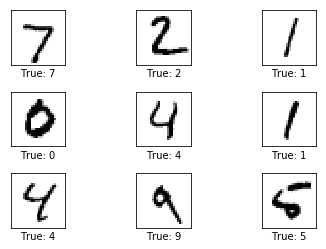

In [9]:
#Ploting first 9 imgaes of numbers to test plot_images function
plot_images(data.test.images[0:9],data.test.cls[0:9])

In [10]:
#helper function for creating new convolution layer
def new_convolution_layer(input_data,
                         num_input_channel,
                         filter_size,
                         num_filter,
                         max_pool=True):
    #shape of filter weights for convolution
    sh=[filter_size,filter_size,num_input_channel,num_filter]
    #weight is a parameter which has to be updated internally during optimization process 
    #which means weights has to be a variable in tensorflow
    
    W= tf.Variable(tf.truncated_normal(sh, stddev=0.05))
    b= tf.Variable(tf.constant(0.05, shape=[num_filter]))
    
    layer =  tf.nn.conv2d(input=input_data,
                         filter=W ,
                         strides=[1,1,1,1],
                         padding='SAME')
    layer +=b
    if max_pool:
        layer=tf.nn.max_pool(value=layer,
                      ksize=[1, 2, 2, 1],
                       strides=[1, 2, 2, 1],
                       padding='SAME')
        
    #relu rectifier activation function zero all the negative pixels and add some non linearity to the function which 
    # enables the network to learn more complicated functions
    layer=tf.nn.relu(layer)
    
    return layer, W
        

In [11]:
#Flattening a layer is new layer item will be imghight*imgweight*channels
def flatten_layer(layer):
     # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features
    


In [12]:
#helper function for creating fully connected layer
#it will have two parameters Weights and baise
#Weights size will be (number of input from previous layer, number of neurons in current layer)
#Bais size will be (numof neurons in current layer,1)
def new_fc_layer(layer_flat,
                 input_size,
                 output_size,
                 use_relu = True):
    W=tf.Variable(tf.truncated_normal([input_size,output_size], stddev=0.05))
    b= tf.Variable(tf.constant(0.05, shape=[output_size]))
    
    layer = tf.matmul(layer_flat, W) + b
    
    if use_relu:
        layer= tf.nn.relu(layer)
    
    return layer
    
    

In [13]:
# place holders for passing values to computation graphs
x= tf.placeholder(tf.float32,shape=[None,img_flat],name='x')

In [14]:
x_image=tf.reshape(x,[-1,img_size,img_size,num_channel])

In [15]:
y= tf.placeholder(tf.float32,shape=[None,num_class],name='y')

In [16]:
y_image=tf.argmax(y,axis=1)

In [17]:
#Creates first convolution layer
layer_1,W_1 = new_convolution_layer(x_image,num_channel,f_size1,num_f1,max_pool=True)

In [18]:
layer_1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

In [19]:
W_1

<tf.Variable 'Variable:0' shape=(5, 5, 1, 16) dtype=float32_ref>

In [20]:
#creates second convolution layer
layer_2,w_2=new_convolution_layer(layer_1,num_f1,f_size2,num_f2,max_pool=True)

In [21]:
layer_2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

In [22]:
w_2

<tf.Variable 'Variable_2:0' shape=(5, 5, 16, 36) dtype=float32_ref>

In [23]:
layer2_flat,num_feature=flatten_layer(layer_2)

In [24]:
layer2_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [25]:
layer_3 = new_fc_layer(layer2_flat,num_feature,fc_size,use_relu=True)

In [26]:
layer_3

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

In [27]:
layer_4 = new_fc_layer(layer_3,fc_size,num_class,use_relu=False)

In [28]:
layer_4

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

In [29]:
#The second fully-connected layer estimates how likely it is that the input image belongs to each of the 10 classes. 
#However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, 
#so we want to normalize them so that each element is limited between zero and one and the 10 elements sum to one. 
#This is calculated using the so-called softmax function and the result is stored in y_pred.
y_pred=tf.nn.softmax(layer_4)
y_pred_class= tf.argmax(y_pred,axis=1)

In [30]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_4,
                                                        labels=y)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [31]:
cost = tf.reduce_mean(cross_entropy)

In [32]:
#optimization
optimizer= tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [33]:
correct_prediction = tf.equal(y_pred_class, y_image)

In [34]:

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [35]:
session= tf.Session()
#we need to initailize the variables W,b first before starting optimization
session.run(tf.global_variables_initializer())

In [36]:
# Mini batches having size 64,128,256 etc
train_batch_size=64


In [37]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))



In [38]:
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_class, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

In [39]:
print_test_accuracy()

Accuracy on Test-Set: 7.1% (711 / 10000)


In [40]:
optimize(2)

Optimization Iteration:      1, Training Accuracy:   3.1%
Time usage: 0:00:01


In [41]:
optimize(100)

Optimization Iteration:    101, Training Accuracy:  64.1%
Time usage: 0:00:14


In [ ]:
print_test_accuracy()

In [42]:
optimize(900)

Optimization Iteration:    201, Training Accuracy:  92.2%
Optimization Iteration:    301, Training Accuracy:  89.1%
Optimization Iteration:    401, Training Accuracy:  92.2%
Optimization Iteration:    501, Training Accuracy:  87.5%
Optimization Iteration:    601, Training Accuracy:  82.8%
Optimization Iteration:    701, Training Accuracy:  90.6%
Optimization Iteration:    801, Training Accuracy:  92.2%
Optimization Iteration:    901, Training Accuracy:  93.8%
Optimization Iteration:   1001, Training Accuracy:  92.2%
Time usage: 0:02:43


In [43]:
print_test_accuracy()

Accuracy on Test-Set: 93.3% (9335 / 10000)
